<h1><center>EE778: Optimal control</center></h1>
<h2><center>Optimal control of 2D undulating motion</center></h2>

## Introduction
Surge-cast is one of the most prominent reactive behavior of insect odor response. It is characterized by straight upwind motion with odor encounter, followed by side-to-side casting motion in the absence of odor. In 2D this motion can be modeled as undulating motion, where an agent has an oscillatory motion in the lateral direction along with the forward motion. Undulating motion is also observed in other biological systems such as fish swimming, snake locomotion etc. For the project required for this class, we will consider a simplified model of undulating motion in 2D. 

## Python Initialization
### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sym
import pandas as pd

from sympy import symbols, Eq, solve, simplify, MatrixSymbol
from pprint import pprint
from IPython.display import display, Math, Markdown

from functions import *

%load_ext autoreload
%autoreload 2

### initialization: variables and constants

In [143]:

my_agent = SystemAgent2D()
my_agent.x_dot

Matrix([
[                   F*cos(phi1) - 10*x2],
[                                    x2],
[                   F*sin(phi1) - 10*y2],
[                                    y2],
[-theta1 - theta2 - 100*theta3 + u_freq],
[                                theta3],
[                                theta2],
[           -phi1 - phi2 + tau + theta1],
[                                  phi2]])

## Model
The model assumes a point mass agent moving in 2D space with three control inputs: force ($F$) in the forward direction, torque ($\tau$) to change the heading angle, and ($u_{freq}$) to change the frequency of the undulating motion. The agent has 9 states.

states: $\vec{x} = [x_2, x_1, y_2, y_1, \theta_3, \theta_2, \theta_1]^T, \phi_2, \phi_1$ where $x_2, y_2$ are the velocity in the forward and lateral direction, $x_1, y_1$ are the position in the forward and lateral direction, $\theta_3, \theta_2, \theta_1$ are oscillatory motion and $\phi_2, \phi_1$ are the heading angles.

dynamic equations:
$$
\begin{align*}
\dot{x}_2 &= -c_1 x_2 + F \cos(\phi_1)\\
\dot{x}_1 &= x_2\\
\dot{y}_2 &= -c_2 y_2 + F \sin(\phi_1)\\
\dot{y}_1 &= y_2\\
\dot{\theta}_3 &= -c_3 \theta_3 - c_4 \theta_2 - c_5 \theta_1 + u_{freq}\\
\dot{\theta}_2 &= \theta_3\\
\dot{\theta}_1 &= \theta_2\\
\dot{\phi}_2 &= -c_6 \phi_2 - c_7 \phi_1 + \tau\\
\dot{\phi}_1 &= \phi_2
\end{align*}
$$
where, $c_1, c_2, c_3, c_4, c_5, c_6, c_7$ are system constants.

The system is nonlinear. So, to estimate the optimal control, we will use the Pontryagin's minimum principle which states that the hamiltonian $H$ is minimized at the optimal control. 

## Sample responses

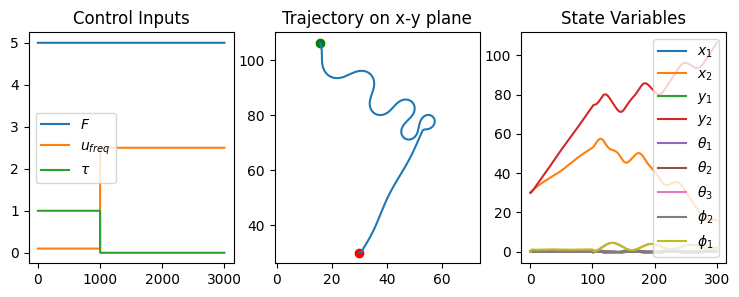

In [3]:
T = 300
dt = .1
N = int(T/dt)
timeseries = np.linspace(0, T, N)

def sample_response(state, t):
    F, u_freq, tau = sample_control(state, t)
    xdot = f(state, [F, u_freq, tau])
    # xdot = my_agent.f(state, [F, u_freq, tau])
    return xdot

def sample_control(state, t):
    F = 5
    if t < 100:
        u_freq = .1
        tau = 1
    else:
        u_freq = 2.5
        tau = 0
    return [F, u_freq, tau]    

initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]
result = sp.integrate.odeint(sample_response, initial_state, timeseries)
xx,yy = result[:,1], result[:,3]
inputs = [sample_control(result[i], timeseries[i]) for i in range(len(result))]

fig, [ax,bx,cx] = plt.subplots(1,3, figsize=(9,3))
ax.plot(inputs, label=['$F$', '$u_{freq}$', '$\\tau$'])
ax.legend()
ax.set_title('Control Inputs')
bx.plot(xx, yy)
bx.scatter(xx[0], yy[0], c='r')
bx.scatter(xx[-1], yy[-1], c='g')
bx.axis('equal')
bx.set_title('Trajectory on x-y plane')
cx.plot(timeseries, result, label=['$x_1$', '$x_2$', '$y_1$', '$y_2$', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$', '$\\phi_2$', '$\\phi_1$'])
cx.legend()
cx.set_title('State Variables')
plt.show()

In the above plot, the agent starts from $(30,30)$ and for the first 100 seconds, it moves with low frequency undulating motion. After 100 seconds, the frequency of the undulating motion is increased and the agent moves with high frequency undulating motion. Both the frequency and torque changes agent's heading angle. The state variables have responses that are combination of multiple sinusoidal functions.


In this project, we aim to control the agent to reach a target position $(x_{1_{target}}, y_{1_{target}})$ from an initial position $(x_{1_{initial}}, y_{1_{initial}})$ with oscillatory motion.

# optimal control 
In this project, we will focus on general nonlinear optimal control problem. The objective is to minimize the cost function $J$ at the final time $T$. 

In [182]:
T = 100
dt = 1
N = int(T/dt)
timeseries = np.linspace(0, T, N)
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]       # initial state
rN = [0, 0, 0, 0, 0, 0, 0, 0, 0]                    # final state
S = np.eye(9)
r_vals = np.array([1, 1, 1])
q_vals = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

my_agent = SystemAgent2D()
r1, r2, r3 = symbols('r1 r2 r3')
q1, q2, q3, q4, q5, q6, q7, q8, q9 = symbols('q1 q2 q3 q4 q5 q6 q7 q8 q9')
R = sym.diag(r1, r2, r3)
Q = sym.diag(q1, q2, q3, q4, q5, q6, q7, q8, q9)
rN = sym.Matrix(rN)

display(Markdown('Cost function: $J(t_0) = (x - r_N)^T Q (x - r_N) + \int_{t_0}^T (u^T R u + x^T Q x) dt$'))
J = (my_agent.states - rN).T * Q * (my_agent.states - rN) + my_agent.u.T * R * my_agent.u
display(sym.Eq(sym.Symbol('J'), J, evaluate=False))

# L = my_agent.u.dot(my_agent.u)
L = my_agent.u.T * R * my_agent.u + my_agent.states.T * Q * my_agent.states
L = L[0]
display(sym.Eq(sym.Symbol('L'), L))

phi = (my_agent.states - rN).T * S * (my_agent.states - rN)
# display(sym.Eq(sym.Symbol('phi'), phi))
display(sym.Eq(sym.Symbol('phi'), phi, evaluate=False))

hamiltonian = L + my_agent.lmdas.dot(my_agent.x_dot)
display(sym.Eq(sym.Symbol('H'), hamiltonian))

display(Markdown('Hamiltonian: $H = L + \lambda^T \dot{x}$'))
display(Markdown('Now we estimate state, costate and stationary equation'))

lmdadot = -sym.diff(hamiltonian, my_agent.states)
display(sym.Eq(sym.Derivative(sym.Symbol('lambda'), sym.Symbol('t')), lmdadot, evaluate=False))

optimal_u = sym.diff(hamiltonian, my_agent.u)
display(sym.Eq(sym.Derivative(sym.Symbol('H'), sym.Symbol('u')), optimal_u, evaluate=False))
eq2 = sym.Eq(optimal_u, sym.zeros(3,1))
display(eq2)
optimal_u = sym.solve(eq2, my_agent.u)
display(Markdown('Optimal Control: $u^* = {}$'.format(optimal_u)))
display(optimal_u)

display(Markdown('Now we solve for $\dot{\lambda}$ with the optimal control'))
lmdadot = lmdadot.subs(optimal_u)
# display(lmdadot)
display(sym.Eq(sym.Derivative(sym.Symbol('lambda'), sym.Symbol('t')), lmdadot, evaluate=False))

display(sym.Eq(sym.Symbol('\dot{x}'), my_agent.x_dot, evaluate=False))



Cost function: $J(t_0) = (x - r_N)^T Q (x - r_N) + \int_{t_0}^T (u^T R u + x^T Q x) dt$

Eq(J, Matrix([[F**2*r1 + phi1**2*q9 + phi2**2*q8 + q1*x2**2 + q2*x1**2 + q3*y2**2 + q4*y1**2 + q5*theta3**2 + q6*theta2**2 + q7*theta1**2 + r2*u_freq**2 + r3*tau**2]]))

Eq(L, F**2*r1 + phi1**2*q9 + phi2**2*q8 + q1*x2**2 + q2*x1**2 + q3*y2**2 + q4*y1**2 + q5*theta3**2 + q6*theta2**2 + q7*theta1**2 + r2*u_freq**2 + r3*tau**2)

Eq(phi, Matrix([[1.0*phi1**2 + 1.0*phi2**2 + 1.0*theta1**2 + 1.0*theta2**2 + 1.0*theta3**2 + 1.0*x1**2 + 1.0*x2**2 + 1.0*y1**2 + 1.0*y2**2]]))

Eq(H, F**2*r1 + lambda1*(F*cos(phi1) - 10*x2) + lambda2*x2 + lambda3*(F*sin(phi1) - 10*y2) + lambda4*y2 + lambda5*(-theta1 - theta2 - 100*theta3 + u_freq) + lambda6*theta3 + lambda7*theta2 + lambda8*(-phi1 - phi2 + tau + theta1) + lambda9*phi2 + phi1**2*q9 + phi2**2*q8 + q1*x2**2 + q2*x1**2 + q3*y2**2 + q4*y1**2 + q5*theta3**2 + q6*theta2**2 + q7*theta1**2 + r2*u_freq**2 + r3*tau**2)

Hamiltonian: $H = L + \lambda^T \dot{x}$

Now we estimate state, costate and stationary equation

Eq(Derivative(lambda, t), Matrix([
[                                 10*lambda1 - lambda2 - 2*q1*x2],
[                                                       -2*q2*x1],
[                                 10*lambda3 - lambda4 - 2*q3*y2],
[                                                       -2*q4*y1],
[                            100*lambda5 - lambda6 - 2*q5*theta3],
[                                lambda5 - lambda7 - 2*q6*theta2],
[                                lambda5 - lambda8 - 2*q7*theta1],
[                                  lambda8 - lambda9 - 2*phi2*q8],
[F*lambda1*sin(phi1) - F*lambda3*cos(phi1) + lambda8 - 2*phi1*q9]]))

Eq(Derivative(H, u), Matrix([
[2*F*r1 + lambda1*cos(phi1) + lambda3*sin(phi1)],
[                         lambda5 + 2*r2*u_freq],
[                            lambda8 + 2*r3*tau]]))

Eq(Matrix([
[2*F*r1 + lambda1*cos(phi1) + lambda3*sin(phi1)],
[                         lambda5 + 2*r2*u_freq],
[                            lambda8 + 2*r3*tau]]), Matrix([
[0],
[0],
[0]]))

Optimal Control: $u^* = {F: -lambda1*cos(phi1)/(2*r1) - lambda3*sin(phi1)/(2*r1), tau: -lambda8/(2*r3), u_freq: -lambda5/(2*r2)}$

{F: -lambda1*cos(phi1)/(2*r1) - lambda3*sin(phi1)/(2*r1),
 tau: -lambda8/(2*r3),
 u_freq: -lambda5/(2*r2)}

Now we solve for $\dot{\lambda}$ with the optimal control

Eq(Derivative(lambda, t), Matrix([
[                                                                                                                                           10*lambda1 - lambda2 - 2*q1*x2],
[                                                                                                                                                                 -2*q2*x1],
[                                                                                                                                           10*lambda3 - lambda4 - 2*q3*y2],
[                                                                                                                                                                 -2*q4*y1],
[                                                                                                                                      100*lambda5 - lambda6 - 2*q5*theta3],
[                                                                                                   

Eq(\dot{x}, Matrix([
[                   F*cos(phi1) - 10*x2],
[                                    x2],
[                   F*sin(phi1) - 10*y2],
[                                    y2],
[-theta1 - theta2 - 100*theta3 + u_freq],
[                                theta3],
[                                theta2],
[           -phi1 - phi2 + tau + theta1],
[                                  phi2]]))

Now, we integrate $\lambda$ and $x$ to get time dependent solution for $\lambda(t)$ and $x(t)$.

In [179]:
lmda_func = sym.Function('lambda')(sym.Symbol('t'))
lmda_t = []

for i in range(len(my_agent.states)):
    expression = lmdadot[i].subs(my_agent.lmdas[i], lmda_func) - lmda_func.diff(sym.Symbol('t'))
    ode_result = sym.dsolve(expression)
    ode_result = ode_result.rhs.subs(sym.Symbol('C1'), sym.Symbol(f'C{i+1}'))
    lmda_t.append(ode_result)
    
lmda_t = sym.Matrix(lmda_t)
# display(lmda_t)
display(sym.Eq(sym.Function('lambda')(sym.Symbol('t')), lmda_t , evaluate=False))

x_func = sym.Function('x')(sym.Symbol('t'))
x_t = []

xdot = my_agent.x_dot.subs(optimal_u)

for i in range(len(my_agent.states)):
    expression = xdot[i].subs(my_agent.states[i], x_func) - x_func.diff(sym.Symbol('t'))
    ode_result = sym.dsolve(expression)
    ode_result = ode_result.rhs.subs(sym.Symbol('C1'), sym.Symbol(f'D{i+1}'))
    x_t.append(ode_result)
x_t = sym.Matrix(x_t)
# display(x_t)
display(sym.Eq(sym.Function('x')(sym.Symbol('t')), x_t , evaluate=False))

Eq(lambda(t), Matrix([
[                                                                                                    C1*exp(10*t) + lambda2/10 + q1*x2/5],
[                                                                                                                         C2 - 2*q2*t*x1],
[                                                                                                    C3*exp(10*t) + lambda4/10 + q3*y2/5],
[                                                                                                                         C4 - 2*q4*t*y1],
[                                                                                             C5*exp(100*t) + lambda6/100 + q5*theta3/50],
[                                                                                             C6 + lambda5*t - lambda7*t - 2*q6*t*theta2],
[                                                                                             C7 + lambda5*t - lambda8*t - 2*q7*t*theta1],
[   

Eq(x(t), Matrix([
[D1*exp(-10*t) - lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1)],
[                                                                                  D2 + t*x2],
[D3*exp(-10*t) - lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1)],
[                                                                                  D4 + t*y2],
[                                D5*exp(-100*t) - lambda5/(200*r2) - theta1/100 - theta2/100],
[                                                                              D6 + t*theta3],
[                                                                              D7 + t*theta2],
[                                                D8*exp(-t) - lambda8/(2*r3) - phi1 + theta1],
[                                                                                D9 + phi2*t]]))

our job is now to find unknown constants in the above equations. This is known as split boundary value problem. In the book, there are two methods discussed (page 131):
1. Iterative method with sensitivity analysis
2. Unit method

We will use unit method to solve the split boundary value problem in this project.

The final time $dT$ is assumed constant to reduce complexity. There are 2n unknowns in the problem. n conditions are given by $x(0) = r(0)$ and n conditions are given by $\lambda(T) = s(x(T) - r(T))$. 

## Unit method
we will first use $x(0) = r(0)$ to find n unknowns. We will then find the expression for $x(T)$ and replace that in $\lambda(T) = s(x(T) - r(T))$. Lastly, we will solve $\lambda$ at $T$ and compare it with the $\lambda(T)$ obtained.

In [189]:
xt0 = x_t.subs(sym.Symbol('t'), 0)  
# display(xt0)
display(sym.Eq(sym.Function('x')(0), sym.Matrix(initial_state), evaluate=False))
display(sym.Eq(sym.Matrix(initial_state), xt0, evaluate=False))

# eq = sym.Eq(xt0, np.zeros((9,1)))
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]
solution = []
for i in range(len(my_agent.states)):
    eq = sym.Eq(xt0[i], initial_state[i])
    val = sym.solve(eq, sym.symbols(f'D{i+1}'))[0]
    val = x_t[i].subs(sym.symbols(f'D{i+1}'), val)
    solution.append(val)
solution = sym.Matrix(solution)
display(solution)
states_t0 = solution

Eq(x(0), Matrix([
[ 0],
[30],
[ 0],
[30],
[ 0],
[ 0],
[ 0],
[ 0],
[ 0]]))

Eq(Matrix([
[ 0],
[30],
[ 0],
[30],
[ 0],
[ 0],
[ 0],
[ 0],
[ 0]]), Matrix([
[D1 - lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1)],
[                                                                              D2],
[D3 - lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1)],
[                                                                              D4],
[                                 D5 - lambda5/(200*r2) - theta1/100 - theta2/100],
[                                                                              D6],
[                                                                              D7],
[                                             D8 - lambda8/(2*r3) - phi1 + theta1],
[                                                                              D9]]))

Matrix([
[-lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1) + (lambda1*cos(2*phi1) + lambda1 + lambda3*sin(2*phi1))*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*x2 + 30],
[-lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1) + (lambda1*sin(2*phi1) - lambda3*cos(2*phi1) + lambda3)*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*y2 + 30],
[                                                  -lambda5/(200*r2) - theta1/100 - theta2/100 + (lambda5 + 2*r2*(theta1 + theta2))*exp(-100*t)/(200*r2)],
[                                                                                                                                               t*theta3],
[                                                            

We now create an augmented matrix $[x, \lambda]$ and solve for the unknowns.

In [198]:
# augmented_states = sym.Matrix([x_t, lmda_t])
augmented_states = sym.Matrix([states_t0, lmda_t])
# display(augmented_states)
display(sym.Eq(sym.Matrix([sym.Function('x')(sym.Symbol('t')), sym.Function('lambda')(sym.Symbol('t'))]), augmented_states, evaluate=False))
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]

display(Markdown('Now we create the unit vectors so that linear combination of them will give any $\lambda$ at $t_0$'))
lambda_0 = np.eye(9)
display(sym.Matrix(lambda_0))

# sub1 = {my_agent.states[i]: initial_state[i] for i in range(len(my_agent.states))}
# sub2 = {my_agent.lmdas[i]: lambda_0[i] for i in range(len(my_agent.lmdas))}
# val = augmented_states.subs(sub1).subs(sub2)
# val
values = np.zeros((18,1))
for i in range(lambda_0.shape[1]):
    lambda_0_i = lambda_0[:,i]
    sub1 = {my_agent.states[i]: initial_state[i] for i in range(len(my_agent.states))}
    sub2 = {my_agent.lmdas[i]: lambda_0_i[i] for i in range(len(my_agent.lmdas))}
    val = augmented_states.subs(sub1).subs(sub2)
    values += val

Eq(Matrix([
[     x(t)],
[lambda(t)]]), Matrix([
[-lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1) + (lambda1*cos(2*phi1) + lambda1 + lambda3*sin(2*phi1))*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*x2 + 30],
[-lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1) + (lambda1*sin(2*phi1) - lambda3*cos(2*phi1) + lambda3)*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*y2 + 30],
[                                                  -lambda5/(200*r2) - theta1/100 - theta2/100 + (lambda5 + 2*r2*(theta1 + theta2))*exp(-100*t)/(200*r2)],
[                                                                                                                                               t*theta3],
[                    

Now we create the unit vectors so that linear combination of them will give any $\lambda$ at $t_0$

Matrix([
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [203]:
display(Markdown('at final time $t = T$'))
values_T = values.subs(sym.Symbol('t'), T)
display(sym.Eq(sym.Matrix([sym.Function('x')(T), sym.Function('lambda')(T)]), values_T, evaluate=False))

sub3 = {r1: r_vals[0], r2: r_vals[1], r3: r_vals[2]}
sub4 = {q1: q_vals[0], q2: q_vals[1], q3: q_vals[2], q4: q_vals[3], q5: q_vals[4], q6: q_vals[5], q7: q_vals[6], q8: q_vals[7], q9: q_vals[8]}

values_T = values_T.subs(sub3).subs(sub4)
display(sym.Eq(sym.Matrix([sym.Function('x')(T), sym.Function('lambda')(T)]), values_T, evaluate=False))

states_T = sym.Matrix(values_T[:9])
states_T = states_T.evalf()
lambda_T = S * (states_T - rN)
display(sym.Eq(sym.Function('lambda')(T), lambda_T, evaluate=False))

C = []
for i in range(len(my_agent.states), len(my_agent.states)*2):
    eq = values_T[i] - lambda_T[i-9]
    val = solve(eq)
    C.append(val)
C = sym.Matrix(C).evalf()
display(Markdown('Finally we solve for $C$'))
display(sym.Eq(sym.Symbol('C'), C, evaluate=False))

at final time $t = T$

Eq(Matrix([
[     x(100)],
[lambda(100)]]), Matrix([
[   -0.05/r1 + 0.05*exp(-1000)/r1],
[                           270.0],
[                               0],
[                           270.0],
[-0.005/r2 + 0.005*exp(-10000)/r2],
[                               0],
[                               0],
[      -0.5/r3 + 0.5*exp(-100)/r3],
[                               0],
[            9*C1*exp(1000) + 0.1],
[                 9*C2 - 54000*q2],
[            9*C3*exp(1000) + 0.1],
[                 9*C4 - 54000*q4],
[          9*C5*exp(10000) + 0.01],
[                            9*C6],
[                            9*C7],
[             9*C8*exp(100) + 1.0],
[                    9*C9 + 100.0]]))

Eq(Matrix([
[     x(100)],
[lambda(100)]]), Matrix([
[   -0.05 + 0.05*exp(-1000)],
[                     270.0],
[                         0],
[                     270.0],
[-0.005 + 0.005*exp(-10000)],
[                         0],
[                         0],
[      -0.5 + 0.5*exp(-100)],
[                         0],
[      9*C1*exp(1000) + 0.1],
[              9*C2 - 54000],
[      9*C3*exp(1000) + 0.1],
[              9*C4 - 54000],
[    9*C5*exp(10000) + 0.01],
[                      9*C6],
[                      9*C7],
[       9*C8*exp(100) + 1.0],
[              9*C9 + 100.0]]))

Eq(lambda(100), Matrix([
[ -0.05],
[ 270.0],
[     0],
[ 270.0],
[-0.005],
[     0],
[     0],
[  -0.5],
[     0]]))

Finally we solve for $C$

Eq(C, Matrix([
[ -8.45993149591576e-437],
[                 6030.0],
[ -5.63995433061051e-437],
[                 6030.0],
[-1.89247310885789e-4346],
[                      0],
[                      0],
[  -6.20012662670139e-45],
[      -11.1111111111111]]))

Now, we can substitute the unknowns in $\lambda(t)$ and $x(t)$ to get the optimal control.

In [204]:
subs = {sym.Symbol(f'C{i+1}'): C[i] for i in range(len(C))}
est_lambda_t = lmda_t.subs(subs).subs(sub3).subs(sub4)
display(sym.Eq(sym.Function('lambda')(sym.Symbol('t')), est_lambda_t, evaluate=False))

est_lambda_T = est_lambda_t.subs(sym.Symbol('t'), T).evalf()
display(sym.Eq(sym.Function('lambda')(T), est_lambda_T, evaluate=False))

Eq(lambda(t), Matrix([
[                                                                                 lambda2/10 + x2/5 - 8.45993149591576e-437*exp(10*t)],
[                                                                                                                    -2*t*x1 + 6030.0],
[                                                                                 lambda4/10 + y2/5 - 5.63995433061051e-437*exp(10*t)],
[                                                                                                                    -2*t*y1 + 6030.0],
[                                                                         lambda6/100 + theta3/50 - 1.89247310885789e-4346*exp(100*t)],
[                                                                                                  lambda5*t - lambda7*t - 2*t*theta2],
[                                                                                                  lambda5*t - lambda8*t - 2*t*theta1],
[                        

Eq(lambda(100), Matrix([
[                                                                                                    0.1*lambda2 + 0.2*x2 - 0.0166666666666667],
[                                                                                                                            6030.0 - 200.0*x1],
[                                                                                                    0.1*lambda4 + 0.2*y2 - 0.0111111111111111],
[                                                                                                                            6030.0 - 200.0*y1],
[                                                                                             0.01*lambda6 + 0.02*theta3 - 0.00166666666666667],
[                                                                                                 100.0*lambda5 - 100.0*lambda7 - 200.0*theta2],
[                                                                                                 100.0*l

The last thing we need to find states with optimal control is to solve the differential states equations with the optimal control. But, $u^*$ depends on the costate $\lambda$ and costate depends on the states. So, we need to solve the differential equations simultaneously.

First, costates $\lambda$ are solved using states and equations above. The optimal control $u^*$ is then calculated using the costates. We then pass the states and optimal control to the dynamic equations to get $\delta x$ at each time step. Using odeint, we can integrate the states to get the optimal trajectory.

In [209]:


def optimal_response(state, t):
    print(t)
    x2, x1, y2, y1, theta3, theta2, theta1, phi2, phi1 = state
    sub_states = {my_agent.states[i]: state[i] for i in range(len(my_agent.states))}
    lambda_values = est_lambda_t.subs(sub_states).subs(sym.Symbol('t'), t)
    # display(lambda_values.evalf())
    aa = solve(sym.Eq(lambda_values, my_agent.lmdas))
    if isinstance(aa, list):
        aa = aa[0]
    # display(aa)
    lambda_values = sym.Matrix([aa[my_agent.lmdas[i]] for i in range(len(my_agent.lmdas))]).evalf()
    # display(lambda_values)
    optimal_u_values = sym.Matrix([optimal_u.get(uu) for uu in my_agent.u])
    optimal_u_values = optimal_u_values.subs(sub_states).subs(sym.Symbol('t'), t).subs(subs).subs(sub3).subs(sub4).subs(aa)
    # display(optimal_u_values)
    xdot = my_agent.f(state, optimal_u_values)
    return xdot
    

optimal_response(initial_state, 0)
# result = sp.integrate.odeint(optimal_response, initial_state, timeseries[::10])
# result = sp.integrate.solve_ivp(optimal_response, [0, T], initial_state, t_eval=timeseries[::10], method='BDF', rtol=1, atol=1)


0


array([-301.5       ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    5.55555556,
          0.        ])

## Discussion:
The solution to the optimal control problem does not converge with the given initial and final conditions. There might be many reasons behind why the solution does not converge. One primary reason is nonlinearity of the system. It might be too stiff in some regions and too soft in others. 

## linearized model

The system we have is highly nonlinear. In reality, this system cant be linearized using small angle approximation. But, for the sake of this project, we will use small angle approximation to linearize the system and evaluate the response. 

The linearized system is given by:
$$
\begin{align*}
\dot{x} &= Ax + Bu\\
\end{align*}
$$
where, $A$ and $B$ are matrices that are functions of the system constants and the states.

In [ ]:
my_agent = SystemAgent2D()
display(sym.Eq(sym.Symbol('A'), my_agent.A, evaluate=False))
display(sym.Eq(sym.Symbol('B'), my_agent.B, evaluate=False))

Eq(A, Matrix([
[-10, 0,   0, 0,    0,  0,  0,  0,  0],
[  1, 0,   0, 0,    0,  0,  0,  0,  0],
[  0, 0, -10, 0,    0,  0,  0,  0,  0],
[  0, 0,   1, 0,    0,  0,  0,  0,  0],
[  0, 0,   0, 0, -100, -1, -1,  0,  0],
[  0, 0,   0, 0,    1,  0,  0,  0,  0],
[  0, 0,   0, 0,    0,  1,  0,  0,  0],
[  0, 0,   0, 0,    0,  0,  1, -1, -1],
[  0, 0,   0, 0,    0,  0,  0,  1,  0]]))

Eq(B, Matrix([
[   1, 0, 0],
[   0, 0, 0],
[phi1, 0, 0],
[   0, 0, 0],
[   0, 1, 0],
[   0, 0, 0],
[   0, 0, 0],
[   0, 0, 1],
[   0, 0, 0]]))

from table 3.3-1:

$$
\begin{align*}
J(t_0) &= \frac{1}{2} (x_T - r_T)^T S (x_T - r_T) + \frac{1}{2} \int_{t_0}^{T} \left( (x - r_T)^T Q (x - r_T) + u^T R u \right) dt \\
-\dot{S} &= A^T S + S A - SBR^{-1}B^T S + Q \\
K &= -R^{-1} B^T S \\
u^* &= -Kx
\end{align*}
$$

we have, $S(T)$. We can estimate the differential equation for $S$ using the above equation. We can then solve the differential equation to get $S(t)$ at each time step. We can then calculate $K$ and $u^*$ using the above equations.

In [218]:
sdot = my_agent.A.T * S + S * my_agent.A - S * my_agent.B * R * my_agent.B.T * S + Q
sdot = -sdot.subs(sub3).subs(sub4)
display(sym.Eq(sym.Symbol('\dot{S}'), sdot, evaluate=False))

ss = sym.Function('S')(sym.Symbol('t'))
ss_t = []

for i in range(len(my_agent.states)):
    for j in range(len(my_agent.states)):
        expression = sdot[i,j] - ss.diff(sym.Symbol('t'))
        ode_result = sym.dsolve(expression)
        ode_result = ode_result.rhs.subs(sym.Symbol('C1'), sym.Symbol(f'a{i+1}{j+1}'))
        ss_t.append(ode_result)

ss_t = sym.Matrix(ss_t).reshape(9,9)
# display(ss_t)

ss_T = ss_t.subs(sym.Symbol('t'), T)
# display(ss_T)
solved_values = solve(ss_T - S)[0]
# solved_values = solve(ss_T - S)


ss_t_est = ss_t.subs(solved_values)
display(sym.Eq(sym.Function('S')(sym.Symbol('t')), ss_t_est, evaluate=False))

Eq(\dot{S}, Matrix([
[    20.0, -1.0,           1.0*phi1,    0,     0,    0,    0,    0,  0],
[    -1.0,   -1,                  0,    0,     0,    0,    0,    0,  0],
[1.0*phi1,    0, 1.0*phi1**2 + 19.0, -1.0,     0,    0,    0,    0,  0],
[       0,    0,               -1.0,   -1,     0,    0,    0,    0,  0],
[       0,    0,                  0,    0, 200.0,    0,  1.0,    0,  0],
[       0,    0,                  0,    0,     0,   -1, -1.0,    0,  0],
[       0,    0,                  0,    0,   1.0, -1.0,   -1, -1.0,  0],
[       0,    0,                  0,    0,     0,    0, -1.0,  2.0,  0],
[       0,    0,                  0,    0,     0,    0,    0,    0, -1]]))

Eq(S(t), Matrix([
[    20.0*t - 1999.0, 100.0 - 1.0*t,                         phi1*t - 100.0*phi1,           0.0,               0.0,           0.0,           0.0,           0.0,       0.0],
[      100.0 - 1.0*t,     101.0 - t,                                         0.0,           0.0,               0.0,           0.0,           0.0,           0.0,       0.0],
[phi1*t - 100.0*phi1,           0.0, phi1**2*t - 100.0*phi1**2 + 19.0*t - 1899.0, 100.0 - 1.0*t,               0.0,           0.0,           0.0,           0.0,       0.0],
[                0.0,           0.0,                               100.0 - 1.0*t,     101.0 - t,               0.0,           0.0,           0.0,           0.0,       0.0],
[                0.0,           0.0,                                         0.0,           0.0, 200.0*t - 19999.0,           0.0, 1.0*t - 100.0,           0.0,       0.0],
[                0.0,           0.0,                                         0.0,           0.0,               0.0,  

$S$ is a function of both time and states. So, we need to solve the differential equation for $S$ at each time step. We can then calculate $K$ and $u^*$ using the above equations. And then, we can integrate the states to get the optimal trajectory.

In [ ]:

rr = np.array(R.subs(sub3).subs(sub4)).astype(np.float64)
inv_r = sp.linalg.inv(rr)


def linear_response(state, t):
    print(t)
    x2, x1, y2, y1, theta3, theta2, theta1, phi2, phi1 = state
    delx = np.array(state) - np.array(rN).T
    # delx = np.array(state) 
    delx = delx.reshape(9,1).astype(np.float64)
    
    state = delx.flatten()
    
    sub_states = {my_agent.states[i]: state[i] for i in range(len(my_agent.states))}
    sval = ss_t_est.subs(sym.Symbol('t'), t).subs(sub_states)
    
    Kalman_gain = inv_r * my_agent.B.T * sval
    Kalman_gain = np.array(Kalman_gain.subs(sub_states)).astype(np.float64)
    

    u = -Kalman_gain.dot(delx)
    xdot = my_agent.linearized_f(state, u.flatten())
    return xdot.flatten()
    
# linear_response(initial_state, 1)
result = sp.integrate.odeint(linear_response, initial_state, timeseries)

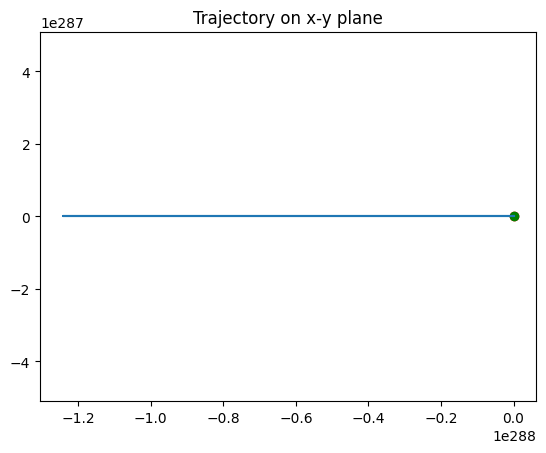

In [220]:
xx,yy = result[:,1], result[:,3]

plt.plot(xx, yy)
plt.scatter(xx[0], yy[0], c='r')
plt.scatter(xx[-1], yy[-1], c='g')
plt.axis('equal')
plt.title('Trajectory on x-y plane')
plt.show()

## Discussion:
Unstable system, did not converge.

In [221]:
a = [[1,2,3],[4,5,6,7]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.